
# Sistem Rekomendasi Film dengan Collaborative Filtering

**Nama:** Berlian Ishma Zhafira Sujana

**Dataset:** MovieLens 25M

**Metode:** Collaborative Filtering dengan Matrix Factorization (SVD)

##1. Import Library

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

##2. Data Understanding

### 2.1 Load Data

In [2]:
path = kagglehub.dataset_download("garymk/movielens-25m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/movielens-25m-dataset


In [ ]:
!ls /kaggle/input/movielens-25m-dataset

ml-25m


In [ ]:
!ls /kaggle/input/movielens-25m-dataset/ml-25m

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [3]:
import pandas as pd

# Path ke folder dataset
base_path = '/root/.cache/kagglehub/datasets/garymk/movielens-25m-dataset/versions/1/ml-25m/'

# Baca file langsung
movies = pd.read_csv(f'{base_path}movies.csv')
ratings = pd.read_csv(f'{base_path}ratings.csv')

In [4]:
movies.shape

(62423, 3)

In [5]:
ratings.shape

(25000095, 4)

In [ ]:
# Tampilkan 5 data pertama
print("Data Film:")
display(movies.head(10))
print("\nData Rating:")
display(ratings.head(10))

Data Film:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller



Data Rating:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


### 🔍 **Insight: Data Understanding**

Notebook ini bertujuan membangun model prediksi rekomendasi film menggunakan **Collaborative Filtering** dengan metode **Matrix Factorization (SVD)**. Dataset yang digunakan adalah **MovieLens 25M Dataset** dari Kaggle. Dataset ini menjelaskan aktivitas pemberian rating rentang 1-5 dan pemberian tag teks bebas dari MovieLens, sebuah layanan rekomendasi film.

Dataset terdiri dari genome-scores.csv, links.csv, ratings.csv, tags.csv
genome-tags.csv, movies.csv, README.txt. Namun pada proyek kali ini hanya akan digunakan 2 dataset yaitu movies.csv dan ratings.csv.

Untuk movies.csv terdiri dari **62423 baris dan 3 kolom**, yang mencakup berbagai aspek seperti:

* **movieId**: pengidentifikasi film
* **title**: judul
* **genres**: genre dari film

Untuk ratings.csv terdiri dari **25000095 baris dan 4 kolom**, yang mencakup berbagai aspek seperti:

* **userId**: pengidentifikasi pengguna
* **movieId**: pengidentifikasi film
* **rating**: ulasan pengguna (rentang 0,5 bintang - 5,0 bintang)
* **timestamp**: mewakili detik sejak tengah malam Waktu Universal Terkoordinasi (UTC) tanggal 1 Januari 1970.

###2.2 Exploratory Data Analysis (EDA)

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [4]:
# Ambil hanya rating dari 1000 pengguna pertama
ratings_reduced = ratings[ratings['userId'] <= 1000]

# Ambil hanya film yang memiliki minimal 3 rating
movie_rating_counts = ratings_reduced['movieId'].value_counts()
popular_movies = movie_rating_counts[movie_rating_counts >= 3].index
ratings_reduced = ratings_reduced[ratings_reduced['movieId'].isin(popular_movies)]

# Gabungkan dengan data film
movies_reduced = movies[movies['movieId'].isin(ratings_reduced['movieId'])]

# Simpan dataset yang sudah dikurangi
ratings_reduced.to_csv('ratings_reduced.csv', index=False)
movies_reduced.to_csv('movies_reduced.csv', index=False)

print(f"Dataset asli: {len(ratings)} rating, {len(movies)} film")
print(f"Dataset reduced: {len(ratings_reduced)} rating, {len(movies_reduced)} film")

Dataset asli: 25000095 rating, 62423 film
Dataset reduced: 135714 rating, 5699 film


In [7]:
movies_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5699 entries, 0 to 61005
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  5699 non-null   int64 
 1   title    5699 non-null   object
 2   genres   5699 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.1+ KB


In [8]:
movies_reduced.isnull().sum()

,0
movieId,0
title,0
genres,0


In [9]:
movies_reduced.duplicated().sum()

np.int64(0)

In [10]:
movies_reduced.describe(include="all")

,movieId,title,genres
count,5699.000000,5699,5699
unique,NaN,5699,766
top,NaN,Joker (2019),Drama
freq,NaN,1,574
mean,31073.970872,NaN,NaN
std,45237.340637,NaN,NaN
min,1.000000,NaN,NaN
25%,2237.000000,NaN,NaN
50%,5008.000000,NaN,NaN
75%,55105.000000,NaN,NaN


In [11]:
movies_reduced.nunique()

,0
movieId,5699
title,5699
genres,766


In [12]:
ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135714 entries, 0 to 143564
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     135714 non-null  int64  
 1   movieId    135714 non-null  int64  
 2   rating     135714 non-null  float64
 3   timestamp  135714 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 5.2 MB


In [ ]:
ratings_reduced.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [ ]:
ratings_reduced.duplicated().sum()

np.int64(0)

In [ ]:
ratings_reduced.describe(include='all')

,userId,movieId,rating,timestamp
count,135714.000000,135714.000000,135714.000000,1.357140e+05
mean,533.520359,18327.587198,3.582438,1.194428e+09
std,296.452157,35056.972616,1.036620,2.343096e+08
min,1.000000,1.000000,0.500000,8.281634e+08
25%,273.000000,1036.000000,3.000000,9.807970e+08
50%,548.000000,2621.000000,4.000000,1.154819e+09
75%,805.000000,6979.000000,4.000000,1.439803e+09
max,1000.000000,204698.000000,5.000000,1.574254e+09


In [ ]:
ratings_reduced.nunique()

,0
userId,1000
movieId,5699
rating,10
timestamp,107704


In [13]:
ratings['rating'].value_counts()

,count
rating,
4.0,6639798
3.0,4896928
5.0,3612474
3.5,3177318
4.5,2200539
2.0,1640868
2.5,1262797
1.0,776815
1.5,399490


In [14]:
ratings_reduced['rating'].value_counts()

,count
rating,
4.0,37279
3.0,27016
5.0,21012
3.5,16082
4.5,11971
2.0,8711
2.5,6395
1.0,3706
1.5,1920


<ipython-input-6-2881266559>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='count_5_star', y='title', data=top_rated, palette="viridis")


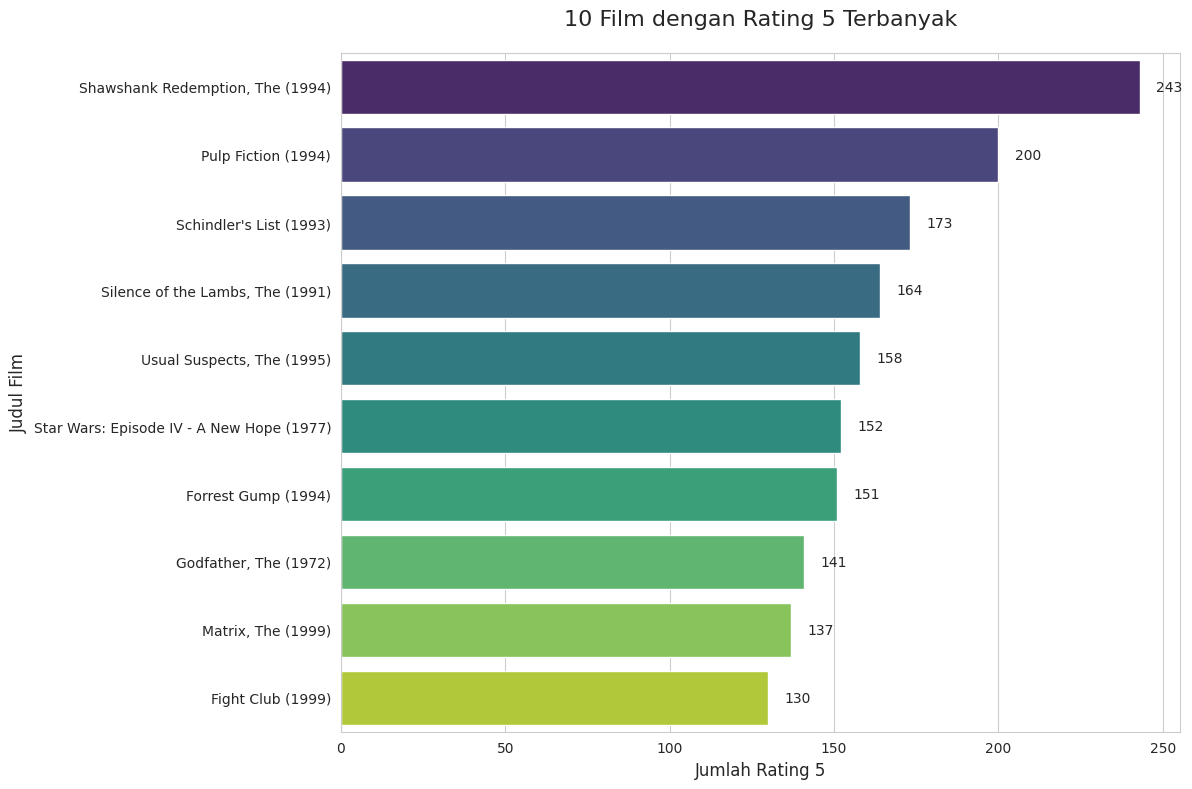

In [6]:
# 2. Filter dan Hitung Rating 5
rating_5 = ratings_reduced[ratings_reduced['rating'] == 5]
movie_5_counts = rating_5['movieId'].value_counts().reset_index()
movie_5_counts.columns = ['movieId', 'count_5_star']

# 3. Gabungkan dengan Data Film
top_rated = movie_5_counts.merge(movies_reduced, on='movieId').sort_values('count_5_star', ascending=False).head(10)

# 4. Visualisasi
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Buat plot bar horizontal
barplot = sns.barplot(x='count_5_star', y='title', data=top_rated, palette="viridis")

# Tambahkan label dan judul
plt.title('10 Film dengan Rating 5 Terbanyak', fontsize=16, pad=20)
plt.xlabel('Jumlah Rating 5', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)

# Tambahkan angka di ujung bar
for i, count in enumerate(top_rated['count_5_star']):
    barplot.text(count + 5, i, f'{count}', ha='left', va='center')

# Atur layout
plt.tight_layout()
plt.show()

<ipython-input-7-2179868898>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='count_ratings', y='title', data=top_movies, palette="viridis")


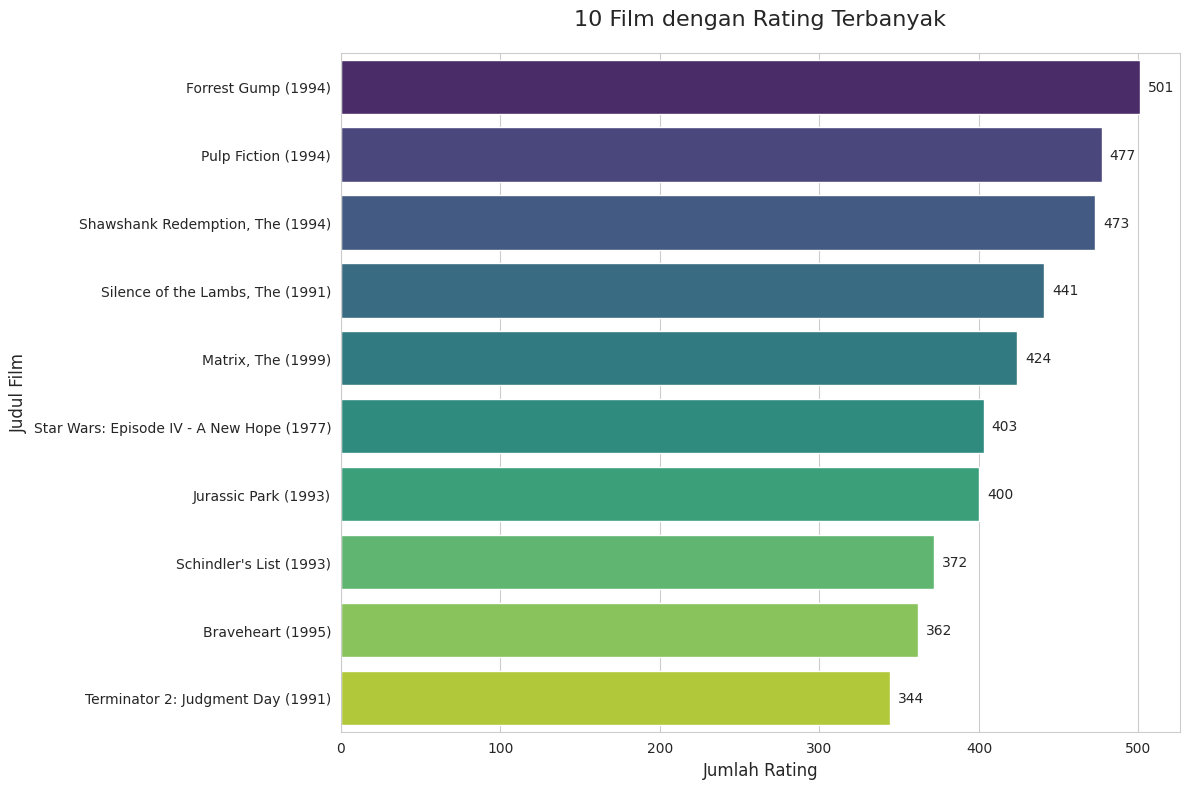

In [7]:
# Hitung jumlah rating per film
movie_ratings_count = ratings_reduced.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count.columns = ['movieId', 'count_ratings']

# Gabungkan dengan data film untuk mendapatkan judul
top_movies = movie_ratings_count.merge(movies, on='movieId').sort_values('count_ratings', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Buat plot bar horizontal
barplot = sns.barplot(x='count_ratings', y='title', data=top_movies, palette="viridis")

# Tambahkan label dan judul
plt.title('10 Film dengan Rating Terbanyak', fontsize=16, pad=20)
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)

# Tambahkan angka di ujung bar
for i, count in enumerate(top_movies['count_ratings']):
    barplot.text(count + 5, i, f'{count}', ha='left', va='center', fontsize=10)

# Atur layout
plt.tight_layout()
plt.show()

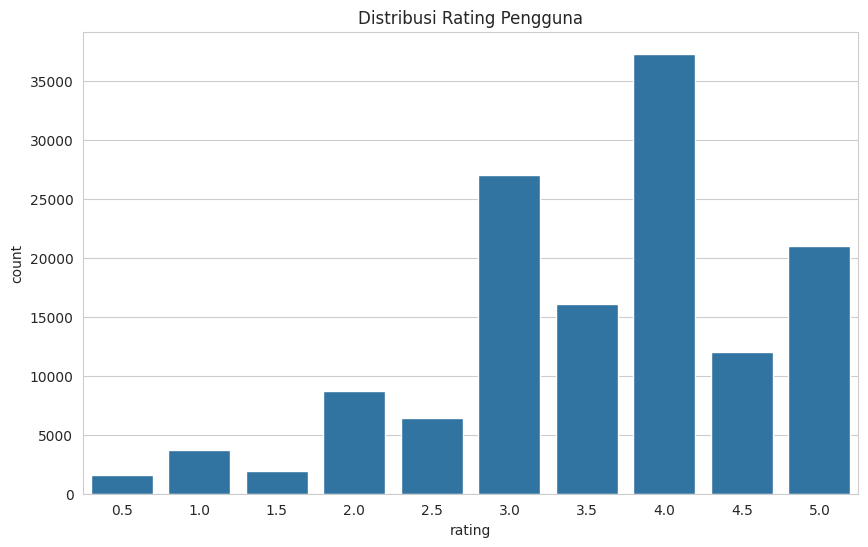

In [17]:
# Visualisasi distribusi rating
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=ratings_reduced)
plt.title('Distribusi Rating Pengguna')
plt.show()

### 🔍 **Insight: Data Understanding**

* Dataset ratings yang awalnya terdiri dari **25000095 baris**, dikurangi hingga **135714  baris** karena RAM tidak menyanggupi dataset yang terlalu banyak. Pengurangan baris didasarkan oleh 1000 pengguna pertama (berdasarkan userId) dan hanya mengambil film yang setidaknya memiliki penilaian sebanyak 3.

* Dataset movies yang awalnya terdiri dari **62423 baris**, dikurangi hingga **5699 baris** karena RAM tidak menyanggupi dataset yang terlalu banyak. Pengurangan baris didasarkan oleh movieId hasil saring ratings_reduced.csv

* **Tidak ditemukan nilai duplikat** dalam dataset. Hal ini penting untuk memastikan tidak ada baris data yang secara tidak sengaja menggandakan informasi pelanggan.

* Untuk memahami keragaman nilai dalam fitur kategorikal seperti `rating` dilakukan eksplorasi menggunakan fungsi `value_counts()` agar mengetahui distribusi tiap jumlah rating.

* Dari hasil visualisasi dataset, didapatkan bahwa:

  * Film dengan judul "The Shawshank Redemption" menjadi film dengan rating 5 terbanyak. Disusul oleh "Pulp Fiction", lalu "Schindler's List".
  * Film dengan judul "Forrest Gump" menjadi film dengan rating terbanyak. Disusul oleh "Pulp Fiction", lalu "The Shawshank Redemption".
  * Rating 4 mendominasi angka rating lainnya. Disusul oleh angka 3, lalu angka 5.

##3. Data Preparation  

###3.1 Data Preprocessing

In [8]:
# Gabungkan data film dan rating
movie_data = pd.merge(ratings_reduced, movies_reduced, on='movieId')

# Buat matriks user-item
user_item_matrix = movie_data.pivot_table(index='userId', columns='title', values='rating').fillna(0)

# Tampilkan ukuran matriks
print(f"Ukuran matriks: {user_item_matrix.shape}")

Ukuran matriks: (1000, 5699)


### 🔍 Insight: Data Preparation
1. **Menggabungkan Data**:
   - Menggabungkan dataframe `ratings_reduced` (berisi data rating) dengan `movies_reduced` (berisi data film)
   - Digabungkan berdasarkan kolom `movieId` yang sama di kedua dataframe
   - Hasilnya adalah dataframe baru yang berisi informasi rating + detail film

2. **Membuat Matriks User-Item**:
   - Membuat matriks dengan:
     - Baris: `userId` (setiap pengguna)
     - Kolom: `title` (judul film)
     - Nilai: `rating` yang diberikan pengguna pada film tersebut
   - `fillna(0)` mengisi nilai kosong dengan 0 (artinya pengguna belum memberi rating)

3. **Menampilkan Ukuran Matriks**:
   - Matriks ini menjadi dasar untuk membangun sistem rekomendasi collaborative filtering di langkah selanjutnya.

##4. Modeling

###4.1 Pelatihan Model

In [9]:
# Konversi ke numpy array
X = user_item_matrix.values

# Split data
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Latih model SVD
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(X_train)

# Hitung RMSE
X_pred = svd.inverse_transform(svd.transform(X_test))
rmse = np.sqrt(mean_squared_error(X_test, X_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 0.4388


### 🔍 Insight: Pelatihan Model
1. **Konversi ke Numpy Array**

   Konversi DataFrame menjadi array (matriks angka) supaya bisa diproses oleh model machine learning. Data ini berisi rating dari user terhadap film

2. **Split Data**
   Data dibagi menjadi dua bagian:
   * **80%** untuk melatih model (X\_train)
   * **20%** untuk menguji model (X\_test)
     Ini bertujuan untuk melihat apakah model bisa bekerja dengan baik pada data baru yang belum pernah dilihat.

3. **Latih Model SVD**

   Di sini kita melatih model **SVD (Singular Value Decomposition)**.
   `n_components=50` berarti menyederhanakan data ke dalam 50 fitur utama — seperti merangkum informasi penting dari data.

4. **Prediksi dan Hitung Error (RMSE)**

* **RMSE (Root Mean Squared Error)** mengukur seberapa besar **rata-rata kesalahan** model dalam membuat prediksi.
* Nilai RMSE ini **berkisar dari 0 ke atas**. Semakin kecil, semakin **akurat** modelnya.
* Nilai **0.4388** berarti model cukup **baik** dalam merekomendasikan item, karena kesalahan rata-rata per prediksi cukup kecil (kurang dari 0.5).
* RMSE di bawah **0.5** cukup bagus, terutama jika skalanya dari 0 sampai 1 atau 5.


In [14]:
def get_recommendations(user_id, n_recommendations=5):
    # Get user ratings
    user_ratings = user_item_matrix.loc[user_id].values.reshape(1, -1)

    # Prediksi rating
    pred_ratings = svd.inverse_transform(svd.transform(user_ratings))
    pred_ratings = pd.Series(pred_ratings[0], index=user_item_matrix.columns)

    # Filter film yang belum ditonton
    watched_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = pred_ratings.drop(watched_movies).sort_values(ascending=False)

    return recommendations.head(n_recommendations)

###🔍 Insight: fungsi get_recommendations()

Fungsi ini digunakan untuk **memberikan saran film** kepada user tertentu berdasarkan data dan model SVD yang telah kamu latih sebelumnya.

1. **Prediksi Rating yang Belum Ada**

* **`svd.transform()`**: mengubah data user ke bentuk fitur yang telah dipelajari model.
* **`svd.inverse_transform()`**: mengembalikan prediksi rating untuk semua film.

Artinya, kita meminta model untuk menebak apabila user ini menonton semua film, kira-kira rating-nya berapa?


2. **Buat Series dari Prediksi**

  Mengubah hasil prediksi jadi daftar berisi:

  * Nama film
  * Prediksi rating dari user

3. **Buang Film yang Sudah Ditonton**

  Karena kita **tidak ingin menyarankan film yang sudah ditonton**, bagian ini akan **membuang** semua film yang user sudah beri rating.

  Lalu, film sisanya **diurutkan dari yang prediksinya paling tinggi ke rendah**.





###4.2 Hasil dan Evaluasi

In [15]:
# Contoh rekomendasi untuk user 1
print("Rekomendasi untuk User 1:")
get_recommendations(1)

Rekomendasi untuk User 1:


,0
title,
Memento (2000),1.204843
Fight Club (1999),1.083986
"Lord of the Rings: The Return of the King, The (2003)",1.040864
"Lord of the Rings: The Fellowship of the Ring, The (2001)",1.017726
Kill Bill: Vol. 1 (2003),0.925349



###🔍 Insight: Hasil
Hasil akhirnya berupa daftar film yang **paling direkomendasikan** oleh model untuk user tersebut.

Hasil untuk User 1:

```
Rekomendasi untuk User 1:
Memento (2000)
Fight Club (1999)
The Lord of the Rings: The Return of the King (2003)
The Lord of the Rings: The Fellowship of the Ring (2001)
Kill Bill: Vol. 1 (2003)
```

**Artinya:**

* Model memprediksi bahwa jika **User 1** menonton film-film di atas, **dia kemungkinan besar akan memberi rating tinggi**. Karena itu, film-film di atas **layak direkomendasikan**.
* Nilai prediksi bisa lebih dari 1 karena SVD tidak dibatasi oleh skala rating awal (misalnya 0–5).
* Semakin tinggi angka `pred_ratings`, semakin besar kemungkinan user akan menyukai film itu, dan angka tertinggi dipegang oleh film dengan judul "Memento".

Sparsity Matrix: 97.62%


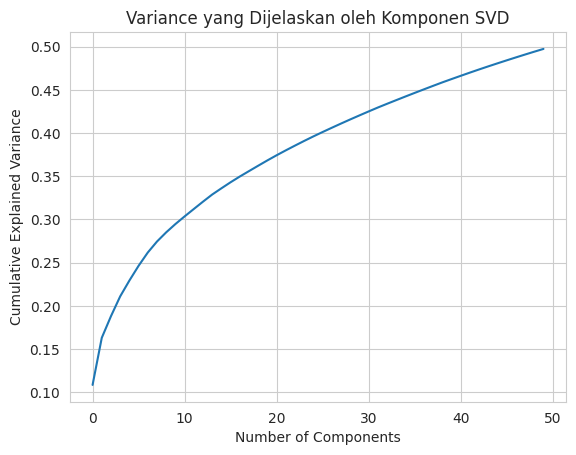

In [16]:
# Hitung sparsity matrix
sparsity = 1 - np.count_nonzero(X) / X.size
print(f"Sparsity Matrix: {sparsity:.2%}")

# Visualisasi variance yang dijelaskan oleh komponen SVD
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance yang Dijelaskan oleh Komponen SVD')
plt.show()

In [18]:
import joblib

# Simpan model
joblib.dump(svd, 'movie_recommender.pkl')

# Simpan user-item matrix
user_item_matrix.to_pickle('user_item_matrix.pkl')

### 🔍 Insight: Evaluasi

1. **Sparsity Matrix**

  * **Sparsity** adalah ukuran seberapa banyak data yang *kosong* atau *nol* dalam sebuah matriks.
  * Dalam konteks sistem rekomendasi, ini berarti **seberapa banyak user belum memberikan rating terhadap film**.
  * Hasil: 97.62%. Artinya **97.62%** dari seluruh isi matriks **tidak memiliki rating (nol)**.

2. **Visualisasi Variance dari Komponen SVD**

  * **Sumbu X (horizontal):** Jumlah komponen SVD yang digunakan, dari 0 hingga 50.
  * **Sumbu Y (vertikal):** Akumulasi **persentase informasi (variance)** dari data asli yang bisa dijelaskan oleh jumlah komponen tersebut.
  * Grafik ini menunjukkan **berapa banyak informasi dari data asli yang bisa dijelaskan oleh sejumlah komponen SVD**.
  * `np.cumsum()` menghitung jumlah akumulatif — semakin banyak komponen yang diambil, semakin banyak informasi yang bisa dijelaskan.


3. **Bentuk grafik naik tapi melandai**
   Ini menunjukkan bahwa:

   * Komponen pertama (awal-awal) **menyumbang banyak informasi**.
   * Semakin banyak komponen ditambahkan, **tambahan informasi yang diperoleh semakin sedikit** (diminishing returns).

4. **50 komponen menjelaskan hampir 50% informasi**

   * Dari grafik, terlihat bahwa dengan **50 komponen**, kamu hanya bisa menjelaskan sekitar **49-50%** dari total informasi dalam data asli.
   * Ini normal untuk data yang sangat sparse (jarang terisi), seperti yang kamu miliki dengan **sparsity 97.62%**.


5. Kesimpulan Umum:

  * **SVD cocok digunakan** karena mampu menangkap pola penting meskipun data sangat kosong.

  * Sparsity tinggi (97.62%) Data sangat jarang diisi rating — cocok pakai model seperti SVD yang bisa memprediksi data hilang.                                 
  * SVD Explained Variance membantu memilih berapa banyak "fitur tersembunyi" (komponen) yang perlu digunakan untuk mendapatkan representasi data yang bagus.
